In [47]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [48]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def square_bonds(): #9 vertices, pbc in x,y - see mathematica nb 
    """
    Defines the connectivity of a square lattice.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    '''bonds = [ #16 vertices, pbc in x,y
        (0, 1), (1, 2), (2, 3), (0, 3),
        (4, 5), (5, 6), (6, 7), (4, 7),
        (8, 9), (9, 10), (10, 11), (8, 11),
        (12, 13), (13, 14), (14, 15), (12, 15),
        (0, 4), (1, 5), (2, 6), (3, 7),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (8, 12), (9, 13), (10, 14), (11, 15),
        (0,12), (1, 13), (2, 14), (3, 15)
    ]'''
    bonds = [
        (0, 1), (1, 2), (0, 2),
        (3, 4), (4, 5), (3, 5),
        (6, 7), (7, 8), (6, 8),
        (0, 3), (1, 4), (2, 5),
        (3, 6), (4, 7), (5, 8),
        (0, 6), (1, 7), (2, 8)
    ]
    return bonds


def transverse_field_ising_square(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 9:
        raise ValueError("N = 9 sites required.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = square_bonds()
    
    # Interaction term: J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, list(range(subsystem_size)), [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, list(range(subsystem_size)), [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, subsystem_size, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(subsystem_size)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [49]:
N = 9
  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

keep_qubits = [0, 1, 3, 4] # square plaquette
# keep_qubits = [0, 1, 4, 5] # square plaquette for 16 sites


# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_square(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [50]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-28.31968441 -23.95925209 -23.95925209 -23.95925209 -23.95925209
 -20.99349582 -20.99349582 -20.99349582 -20.99349582 -19.62096097
 -19.2010386  -19.2010386  -19.2010386  -19.2010386  -18.9306487
 -18.77609617 -18.77609617 -18.77609617 -18.77609617 -16.87701775
 -16.87701775 -16.87701775 -16.87701775 -16.62211741 -16.62211741
 -16.62211741 -16.62211741 -16.01591347 -15.41639693 -15.41639693
 -15.41639693 -15.41639693 -14.1988818  -14.1988818  -14.1988818
 -14.1988818  -14.09827183 -14.06117819 -14.06117819 -14.04187243
 -14.04187243 -14.04187243 -14.04187243 -14.01025993 -14.01025993
 -14.01025993 -14.01025993 -13.65668426 -13.54491474 -13.39793385
 -13.39793385 -13.39793385 -13.39793385 -13.12687914 -13.12687914
 -13.12687914 -13.12687914 -12.38849349 -12.38849349 -12.38849349
 -12.38849349 -11.61819768 -11.61819768 -11.61819768 -11.61819768
 -11.06381566 -11.06381566 -11.06381566 -11.06381566 -10.95371506
 -10.95371506 -10.95371506 -10.95371506 -10.74394318 -10.743

In [51]:
##################### RDMS + EE #################################

In [52]:
'''# rdm - qutip

min_eigenvalues = []
min_rdms = []
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()
    # Check if the rank is not full and print it
    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)
    if rank < traced_out_density_matrix_dense.shape[0]:
        print(f"Traced-out density matrix rank: {rank}")
    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
      min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
      rdm_eigenvalues.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms# Define the threshold - qutip
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - qutip
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] - eigenvalues of the scarred rdms - that are non-zero
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts}')'''

<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
C:\Users\camip\AppData\Local\Temp\ipykernel_17640\734414245.py:45: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(r"$\lambda_{\text{min}}$")


'# rdm - qutip\n\nmin_eigenvalues = []\nmin_rdms = []\nrdm_eigenvalues = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n    # Check if the rank is not full and print it\n    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)\n    if rank < traced_out_density_matrix_dense.shape[0]:\n        print(f"Traced-out density matrix rank: {rank}")\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eigenv

100%|██████████| 512/512 [00:00<00:00, 562.87it/s]


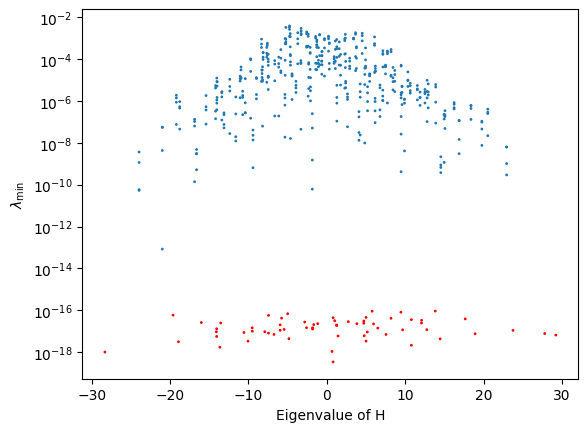

Indices of red points: [0, 9, 14, 27, 36, 37, 38, 47, 48, 77, 82, 87, 88, 113, 130, 131, 132, 141, 142, 147, 148, 161, 162, 195, 196, 221, 222, 223, 224, 237, 266, 267, 268, 273, 278, 283, 288, 313, 330, 343, 344, 345, 354, 355, 356, 365, 366, 379, 396, 401, 414, 427, 440, 441, 450, 451, 456, 465, 470, 491, 496, 509, 510, 511]
0 0
Eigenvalue: -28.31968441304936, rdm Minimum Eigenvalue: -1.004558741988747e-18
Eigenvector 0: rdm rank: 15
1 9
Eigenvalue: -19.620960971806117, rdm Minimum Eigenvalue: -5.841063461283881e-17
Eigenvector 9: rdm rank: 11
2 14
Eigenvalue: -18.93064869897709, rdm Minimum Eigenvalue: -3.1316026083443487e-18
Eigenvector 14: rdm rank: 15
3 27
Eigenvalue: -16.015913474615505, rdm Minimum Eigenvalue: 2.5892031041019734e-17
Eigenvector 27: rdm rank: 15
4 36
Eigenvalue: -14.0982718306876, rdm Minimum Eigenvalue: -9.380659934631087e-18
Eigenvector 36: rdm rank: 15
5 37
Eigenvalue: -14.061178193877382, rdm Minimum Eigenvalue: -5.578675013642672e-18
Eigenvector 37: rdm ran

In [53]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

In [54]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np = []
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

100%|██████████| 512/512 [00:00<00:00, 576.38it/s]


In [55]:
# Create a dictionary to store arrays of min_rdms_np for each unique non-full rank value
min_rdms_by_rank = {}

# Compute the rank for each RDM in min_rdms_np
red_ranks = [np.linalg.matrix_rank(rdm) for rdm in min_rdms_np]

# For each unique non-full rank, collect the corresponding RDMs
for rank in set(red_ranks):
    min_rdms_by_rank[rank] = [rdm for rdm, r in zip(min_rdms_np, red_ranks) if r == rank]

# Now min_rdms_by_rank[rank] is a list of RDMs with that rank
for rank, rdms in min_rdms_by_rank.items():
    print(f"Rank {rank}: {len(rdms)} RDMs")

Rank 9: 2 RDMs
Rank 11: 10 RDMs
Rank 12: 10 RDMs
Rank 14: 16 RDMs
Rank 15: 26 RDMs


In [56]:
# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Find indices of non-full-rank points (min_eigenvalue < threshold)
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of non-full-rank points: {red_indices_np}')

# Compute ranks for each non-full-rank RDM
red_ranks = [np.linalg.matrix_rank(rdm) for rdm in min_rdms_np]
if red_ranks:
    min_rank = min(red_ranks)
    other_ranks = sorted(set(red_ranks) - {min_rank})
else:
    min_rank = None
    other_ranks = []

# Save indices for each unique non-full rank (including min_rank)
rank_to_indices = {}
for idx, rank in enumerate(red_ranks):
    if rank not in rank_to_indices:
        rank_to_indices[rank] = []
    rank_to_indices[rank].append(red_indices_np[idx])

print("Indices for each non-full rank:")
for rank, indices in rank_to_indices.items():
    print(f"Rank {rank}: {len(rank_to_indices[rank])} states with indices {indices}")

# Build color list for all points:
# - smallest rank (min_rank) is red
# - other non-full-rank (but not min_rank) are colored by their rank
# - full rank are 'C0'
rank_to_color = {}
color_palette = ['yellow', 'orange', 'green', 'blue', 'purple', 'brown', 'pink', 'gray']
for idx, rank in enumerate(other_ranks):
    rank_to_color[rank] = color_palette[idx % len(color_palette)]

point_colors = []
red_counter = 0
for i, y in enumerate(min_eigenvalues_np):
    if y < threshold:
        rank = red_ranks[red_counter]
        if rank == min_rank:
            point_colors.append('red')
        else:
            point_colors.append(rank_to_color[rank])
        red_counter += 1
    else:
        point_colors.append('C0')

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.figure(figsize=(8, 5))
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=point_colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'rank={min_rank}', markerfacecolor='red', markersize=8)
]
for rank in other_ranks:
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w',
               label=f'rank={rank}',
               markerfacecolor=rank_to_color[rank], markersize=8)
    )
legend_elements.append(
    Line2D([0], [0], marker='o', color='w', label='Full rank', markerfacecolor='C0', markersize=8)
)
plt.legend(handles=legend_elements, title="RDM Rank")

plt.show()

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for non-full-rank points
for i, ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

Indices of non-full-rank points: [0, 9, 14, 27, 36, 37, 38, 47, 48, 77, 82, 87, 88, 113, 130, 131, 132, 141, 142, 147, 148, 161, 162, 195, 196, 221, 222, 223, 224, 237, 266, 267, 268, 273, 278, 283, 288, 313, 330, 343, 344, 345, 354, 355, 356, 365, 366, 379, 396, 401, 414, 427, 440, 441, 450, 451, 456, 465, 470, 491, 496, 509, 510, 511]
Indices for each non-full rank:
Rank 15: 26 states with indices [0, 14, 27, 36, 82, 88, 113, 132, 162, 223, 224, 237, 266, 288, 345, 356, 366, 379, 427, 451, 456, 470, 496, 509, 510, 511]
Rank 11: 10 states with indices [9, 48, 87, 147, 195, 283, 313, 365, 414, 450]
Rank 14: 16 states with indices [37, 38, 130, 131, 141, 142, 221, 222, 267, 268, 343, 344, 354, 355, 440, 441]
Rank 12: 10 states with indices [47, 77, 148, 196, 278, 330, 396, 401, 465, 491]
Rank 9: 2 states with indices [161, 273]


0 0
Eigenvalue: -28.31968441304936, rdm Minimum Eigenvalue: -1.004558741988747e-18
Eigenvector 0: rdm rank: 15
1 9
Eigenvalue: -19.620960971806117, rdm Minimum Eigenvalue: -5.841063461283881e-17
Eigenvector 9: rdm rank: 11
2 14
Eigenvalue: -18.93064869897709, rdm Minimum Eigenvalue: -3.1316026083443487e-18
Eigenvector 14: rdm rank: 15
3 27
Eigenvalue: -16.015913474615505, rdm Minimum Eigenvalue: 2.5892031041019734e-17
Eigenvector 27: rdm rank: 15
4 36
Eigenvalue: -14.0982718306876, rdm Minimum Eigenvalue: -9.380659934631087e-18
Eigenvector 36: rdm rank: 15
5 37
Eigenvalue: -14.061178193877382, rdm Minimum Eigenvalue: -5.578675013642672e-18
Eigenvector 37: rdm rank: 14
6 38
Eigenvalue: -14.061178193877382, rdm Minimum Eigenvalue: -1.3045828453526734e-17
Eigenvector 38: rdm rank: 14
7 47
Eigenvalue: -13.656684259632659, rdm Minimum Eigenvalue: 1.7048639781321563e-18
Eigenvector 47: rdm rank: 12
8 48
Eigenvalue: -13.544914741872631, rdm Minimum Eigenvalue: -2.4598405182865775e-17
Eigenvec

In [57]:
# decide which non-full rank states to analyze
red_indices_np = rank_to_indices[min_rank]

In [58]:
'''# rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])
    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy()) # store the eigenvalues of the scarred rdms

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_to[i] - eigenvalues of the scarred rdms - that are non-zero
counts_to = [np.sum(eigenvalues > 1e-15) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_to}')'''

<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
C:\Users\camip\AppData\Local\Temp\ipykernel_17640\3775950558.py:42: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(r"$\lambda_{\text{min}}$")


'# rdm - torch\n\nmin_eigenvalues_to = []\nmin_rdms_to = []\nrdm_eigenvalues_to = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)\n    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])\n    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 \n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    min_eigenvalue = torch.min(eigenvalues_traced).item()\n    min_eigenvalues_

In [59]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices_np)) + 1j* np.random.rand(len(red_indices_np))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
rnd_scar = np.sum(eigenvectors[:, red_indices_np] * random_coeffs, axis=1)

print(len(rnd_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices_np])

# Count the number of zero entries
num_zeros = np.count_nonzero((rnd_scar.real < 1e-16) & (rnd_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')

# RANDOM SCAR - RANDOM LINEAR COMBINATION OF SCARRED STATES

rnd_scar = linear_combination_np(random_coeffs, red_eigenvectors_np)
rnd_scar_entropy = entanglement_entropy(rnd_scar, N // 2, N)
#rnd_scar_entropy_qutip = entanglement_entropy_qutip(rnd_scar, N // 2, N)
#rnd_scar_entropy_torch = entanglement_entropy_torch(rnd_scar, N // 2, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {rnd_scar_entropy}")
#print(f"Entanglement entropy of random scar state (Qutip): {rnd_scar_entropy_qutip}")
#print(f"Entanglement entropy of random scar state (PyTorch): {rnd_scar_entropy_torch}")

[0.03832229+0.4268972j  0.87190072+0.23681072j]
coeffs norm 1.0000000000000002
512
Number of zero entries: 277
Random scar coeffs [0.03832229+0.4268972j  0.87190072+0.23681072j]
Entanglement entropy of random scar state: 1.9402296680168136


In [60]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 512/512 [00:00<00:00, 1334.90it/s]


In [61]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 161, Entropy: 3.502016509682614
Index: 273, Entropy: 3.5020165096826195
Random scar entropy: 1.9402296680168136


In [62]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Find the red index with the lowest entanglement entropy
min_entropy_idx = min(red_indices_np, key=lambda i: numpy_entropies[i])
min_entropy_val = numpy_entropies[min_entropy_idx]

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot blue points first
for i, color in enumerate(colors):
    if color != 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)
# Then plot red points on top
for i, color in enumerate(colors):
    if color == 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=4)

# Plot entanglement entropy with highlighted points
#for i, color in enumerate(colors):
#    size = 3 if color == 'red' else 2
#    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=size)

# Mark the scar with the lowest entanglement entropy with a yellow cross
plt.plot(eigenvalues[min_entropy_idx], min_entropy_val, 'x', color='red', markersize=8, label=f'Min EE (idx={min_entropy_idx + 1})')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', markersize=4, label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 161, Entropy: 3.502016509682614
Index: 273, Entropy: 3.5020165096826195


In [63]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - qutip\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {qutip_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_qutip}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], qutip_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

In [64]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - torch

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {torch_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_torch}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], torch_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - torch\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {torch_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_torch}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], torch_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

In [65]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues_np[idx]):.2e}, Entropy: {numpy_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(rnd_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

Entropies of red points:
Index: 161, Entropy: 3.502016509682614
Index: 273, Entropy: 3.5020165096826195
Random scar entropy: 1.9402296680168136


In [66]:
#################### OPTIMAL LINEAR COMBINATION OF SCARS THAT  MINIMIZE/MAXIMIZE EE ##########################

Initial Entropy: 1.968214988708496
Coeffs norm: 1.0
Entropy: 1.9682166576385498
Coeffs: [ 0.25245997-0.09677327j -0.14774542-0.46468902j  0.09770085-0.5753993j
 -0.39769587+0.40790242j  0.11626811+0.10217597j]
Coeffs norm: 1.0
Entropy: 1.9259706735610962
Coeffs: [ 0.26447645-0.1075936j  -0.1388037 -0.45818242j  0.0883748 -0.5898969j
 -0.39067456+0.40095952j  0.10708458+0.09288416j]
Coeffs norm: 1.0
Entropy: 1.8817191123962402
Coeffs: [ 0.2762803 -0.11837532j -0.12963673-0.4511038j   0.0812181 -0.60381895j
 -0.38315412+0.39350522j  0.09772214+0.08342282j]
Coeffs norm: 1.0
Entropy: 1.8355417251586914
Coeffs: [ 0.28792804-0.12913685j -0.12029317-0.4435803j   0.07320684-0.61729574j
 -0.37524626+0.38565284j  0.08823184+0.07383204j]
Coeffs norm: 0.99999994
Entropy: 1.7875936031341553
Coeffs: [ 0.2993907 -0.1398605j  -0.11078135-0.43559572j  0.06471312-0.63026553j
 -0.36694142+0.37739113j  0.07863584+0.06412547j]
Coeffs norm: 0.99999994
Entropy: 1.7380681037902832
Coeffs: [ 0.31064683-0.15053

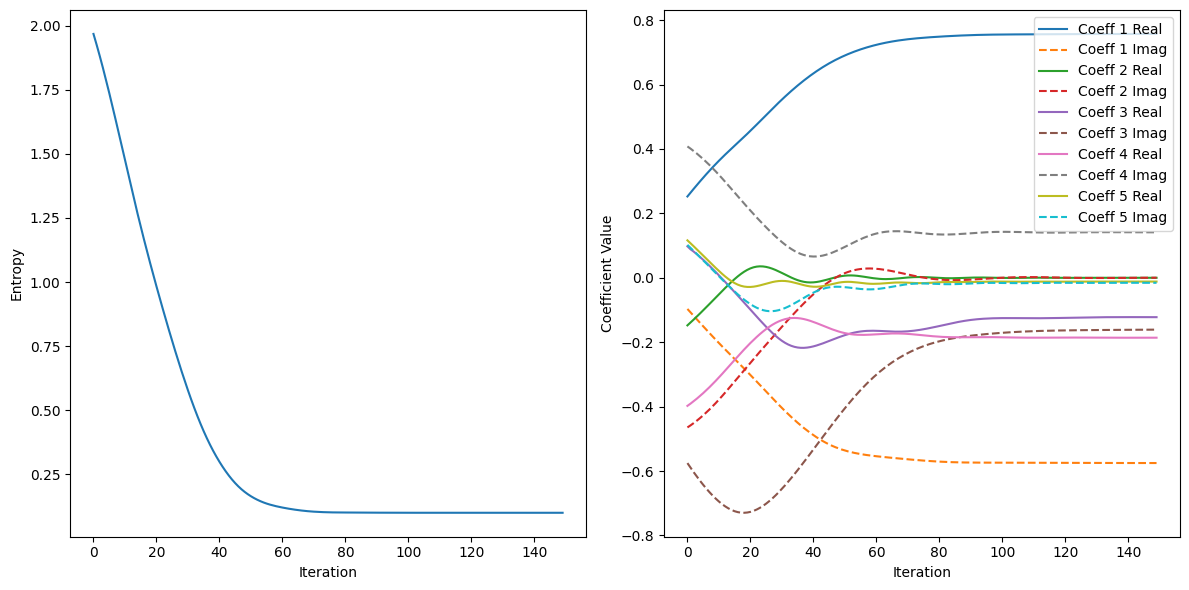

In [67]:
# find entropy min coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
params_real = torch.randn(5, requires_grad=True)
params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

red_eigenvectors = [torch.tensor(vec, dtype=torch.complex64) for vec in red_eigenvectors_np]


#params_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)

# Compute the linear combination using the defined function
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# if the outer products between scarred states are computed before optimization loop
# ....

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
min_scar = linear_combination_np(coeffs_history_min[-1], red_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
min_scar_entropy = entanglement_entropy(min_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Min scar entropy: {min_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
min_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices_np]), min_scar_entropy, 'x', color='black', markersize=7)
handles.append(min_scar_handle)
labels.append('Min Scar, Entropy: {:.2f}'.format(min_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
plt.show()

Entropies of red points:
Index: 161, Entropy: 3.502016509682614
Index: 273, Entropy: 3.5020165096826195
Min scar entropy: 0.09957574412919815


In [69]:
# now find entropy max coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
params_real = torch.randn(5, requires_grad=True)
params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

#params_real = torch.tensor(max_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(max_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Initial coeffs, real tensor([-1.4792,  1.1056, -0.2777, -1.1968,  0.2014], requires_grad=True)
Initial coeffs imag tensor([ 0.0593, -1.5261, -1.0201, -0.2503, -0.4535], requires_grad=True)
Initial Entropy: 1.9471182823181152
Coeffs norm: 1.0
Entropy: 1.9471174478530884
Coeffs: [-0.5043602 +0.02022419j  0.37695447-0.5203338j  -0.09468939-0.34782183j
 -0.4080711 -0.08533344j  0.06867076-0.15460983j]
Coeffs norm: 1.0
Entropy: 1.9775724411010742
Coeffs: [-0.49095073+0.01015368j  0.38428572-0.52667624j -0.08410532-0.33549196j
 -0.41518775-0.09467595j  0.07812819-0.16347454j]
Coeffs norm: 1.0
Entropy: 2.006225347518921
Coeffs: [-0.4772722 +2.0500200e-04j  0.39071658-5.3250617e-01j
 -0.07464995-3.2300952e-01j -0.42191368-1.0388138e-01j
  0.08744348-1.7214058e-01j]
Coeffs norm: 0.99999994
Entropy: 2.0331408977508545
Coeffs: [-0.46350044-0.00956297j  0.39539722-0.5379419j  -0.06864107-0.3105042j
 -0.4283672 -0.11297523j  0.09662302-0.1806466j ]
Coeffs norm: 0.99999994
Entropy: 2.058544397354126

In [70]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history_max[-1], red_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Max scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices_np]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

Entropies of red points:
Index: 161, Entropy: 3.502016509682614
Index: 273, Entropy: 3.5020165096826195
Max scar entropy: 2.8279480779521293


In [71]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [72]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

RDM Index: 0
Number of dependent columns: 1
Dependent columns indices: [13]
--------------------------------------------------
RDM Index: 1
Number of dependent columns: 5
Dependent columns indices: [3, 6, 10, 13, 15]
--------------------------------------------------
RDM Index: 2
Number of dependent columns: 1
Dependent columns indices: [7]
--------------------------------------------------
RDM Index: 3
Number of dependent columns: 1
Dependent columns indices: [14]
--------------------------------------------------
RDM Index: 4
Number of dependent columns: 1
Dependent columns indices: [14]
--------------------------------------------------
RDM Index: 5
Number of dependent columns: 2
Dependent columns indices: [7, 15]
--------------------------------------------------
RDM Index: 6
Number of dependent columns: 2
Dependent columns indices: [13, 15]
--------------------------------------------------
RDM Index: 7
Number of dependent columns: 4
Dependent columns indices: [8, 9, 13, 15]
-----

In [73]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

RDM Index: 0
Null space dimension: 1
Null space basis vectors:
[[-1.10383526e-14]
 [ 2.62502222e-01]
 [-2.62502222e-01]
 [-6.40069658e-14]
 [-2.62502222e-01]
 [-6.52164154e-14]
 [-2.87566348e-15]
 [ 4.25549743e-01]
 [ 2.62502222e-01]
 [ 7.84839705e-15]
 [-6.53551932e-14]
 [-4.25549743e-01]
 [-6.54780113e-14]
 [-4.25549743e-01]
 [ 4.25549743e-01]
 [-7.74743212e-13]]
--------------------------------------------------
RDM 0, Null Basis Vector 0:
Result: [-6.65095880e-18 -1.30104261e-18  1.08420217e-18  3.60170484e-19
  2.16840434e-19  2.67101505e-19 -5.91290140e-19 -1.08420217e-19
  8.67361738e-19  7.32384619e-19  2.56874885e-19 -1.62630326e-19
  2.53800956e-19 -1.89735380e-19  8.13151629e-20 -2.00145854e-20]
Norm of Result: 7.014377240446892e-18
RDM Index: 1
Null space dimension: 5
Null space basis vectors:
[[-0.07092481 -0.09891375 -0.0665798   0.04688956  0.00220171]
 [ 0.21337741 -0.04600175 -0.07490465  0.11930525  0.00101698]
 [ 0.21337741 -0.04600175 -0.07490465  0.11930525  0.0010

In [74]:
# For each RDM, check if any row in its null space basis matrix is (close to) zero
for idx, rdm in enumerate(min_rdms_np):
    null_space_rdm = null_space(rdm)
    for i, row in enumerate(null_space_rdm):
        if np.allclose(row, 0, atol=1e-12):
            print(f"RDM {idx}: Row {i} in null space is (close to) zero.")

RDM 0: Row 0 in null space is (close to) zero.
RDM 0: Row 3 in null space is (close to) zero.
RDM 0: Row 5 in null space is (close to) zero.
RDM 0: Row 6 in null space is (close to) zero.
RDM 0: Row 9 in null space is (close to) zero.
RDM 0: Row 10 in null space is (close to) zero.
RDM 0: Row 12 in null space is (close to) zero.
RDM 0: Row 15 in null space is (close to) zero.
RDM 2: Row 0 in null space is (close to) zero.
RDM 2: Row 3 in null space is (close to) zero.
RDM 2: Row 5 in null space is (close to) zero.
RDM 2: Row 6 in null space is (close to) zero.
RDM 2: Row 9 in null space is (close to) zero.
RDM 2: Row 10 in null space is (close to) zero.
RDM 2: Row 12 in null space is (close to) zero.
RDM 3: Row 0 in null space is (close to) zero.
RDM 3: Row 3 in null space is (close to) zero.
RDM 3: Row 5 in null space is (close to) zero.
RDM 3: Row 6 in null space is (close to) zero.
RDM 3: Row 9 in null space is (close to) zero.
RDM 3: Row 10 in null space is (close to) zero.
RDM 3: 

In [75]:
# Count the number of distinct rows in the null space basis of RDM 0
rdm = min_rdms_np[4]
null_space_rdm = null_space(rdm)

# Use np.allclose to group rows that are numerically identical
distinct_rows = []
for i, row in enumerate(null_space_rdm):
    is_new = True
    for drow in distinct_rows:
        if np.allclose(row, drow, atol=1e-12):
            is_new = False
            break
    if is_new:
        distinct_rows.append(row)

print(f"Number of distinct rows in null space basis of RDM 0: {len(distinct_rows)}")

Number of distinct rows in null space basis of RDM 0: 5


In [76]:
# Print the binary basis states for each group of identical rows in the null space basis of RDM 0 (5 spins)
# Also print the smallest row index for each group

def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

rdm = min_rdms_np[0]
null_space_rdm = null_space(rdm)

# Group row indices by their unique row (up to numerical tolerance)
groups = []
group_indices = []

for i, row in enumerate(null_space_rdm):
    found = False
    for g, grow in enumerate(groups):
        if np.allclose(row, grow, atol=1e-12):
            group_indices[g].append(i)
            found = True
            break
    if not found:
        groups.append(row)
        group_indices.append([i])

print(f"Number of distinct rows: {len(groups)}")
for indices in group_indices:
    basis_states = [index_to_binary(idx, 5) for idx in indices]
    min_row = min(indices)
    print(f"Row {min_row}: Basis states: {', '.join(basis_states)}")

Number of distinct rows: 5
Row 0: Basis states: 00000, 00011, 00101, 00110, 01001, 01010, 01100, 01111
Row 1: Basis states: 00001, 01000
Row 2: Basis states: 00010, 00100
Row 7: Basis states: 00111, 01110
Row 11: Basis states: 01011, 01101


In [77]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

RDM Index: 0
Null space dimension: 1
--------------------------------------------------
Repeating rows in the null space basis vectors for RDM 0:
Row 0 is identical to Row 3
Row 0 is identical to Row 5
Row 0 is identical to Row 6
Row 0 is identical to Row 9
Row 0 is identical to Row 10
Row 0 is identical to Row 12
Row 0 is identical to Row 15
Row 1 is identical to Row 8
Row 2 is identical to Row 4
Row 3 is identical to Row 5
Row 3 is identical to Row 6
Row 3 is identical to Row 9
Row 3 is identical to Row 10
Row 3 is identical to Row 12
Row 3 is identical to Row 15
Row 5 is identical to Row 6
Row 5 is identical to Row 9
Row 5 is identical to Row 10
Row 5 is identical to Row 12
Row 5 is identical to Row 15
Row 6 is identical to Row 9
Row 6 is identical to Row 10
Row 6 is identical to Row 12
Row 6 is identical to Row 15
Row 7 is identical to Row 14
Row 9 is identical to Row 10
Row 9 is identical to Row 12
Row 9 is identical to Row 15
Row 10 is identical to Row 12
Row 10 is identical to R

In [78]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

Full Eigenvector 0:
000000000: -0.9516976833861055
000000001: 0.0
000000010: 0.0
000000011: 0.06977447770554523
000000100: 0.0
000000101: 0.06977447770554523
000000110: 0.06977447770554523
000000111: 0.0
000001000: 0.0
000001001: 0.06977447770554523
000001010: -0.015317079528918243
000001011: 0.0
000001100: -0.015317079528918242
000001101: 0.0
000001110: 0.0
000001111: -0.003638314662136142
000010000: 0.0
000010001: -0.015317079528918242
000010010: 0.06977447770554523
000010011: 0.0
000010100: -0.015317079528918242
000010101: 0.0
000010110: 0.0
000010111: -0.003638314662136142
000011000: 0.06977447770554523
000011001: 0.0
000011010: 0.0
000011011: -0.009954068256486717
000011100: 0.0
000011101: -0.003950309493399347
000011110: -0.003950309493399346
000011111: 0.0
000100000: 0.0
000100001: -0.015317079528918242
000100010: -0.015317079528918242
000100011: 0.0
000100100: 0.06977447770554523
000100101: 0.0
000100110: 0.0
000100111: -0.00363831466213614
000101000: 0.06977447770554523
000101

In [79]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")
    
    # Dictionary to track processed coefficients
    processed_coeffs = set()
    
    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component
            
            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue
            
            # Count the number of 1's in the binary representation
            num_ones = binary_basis.count('1')
            
            # Print the coefficient, binary representation, and number of 1's
            print(f"  Coefficient: {coeff}")
            print(f"    Binary Representation: {binary_basis}")
            print(f"    Elements [0, 1, 3, 4]: {binary_basis[0]}, {binary_basis[1]}, {binary_basis[3]}, {binary_basis[4]}")
            print(f"    Number of 1's: {num_ones}")
            
            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)
                    num_ones_neg = binary_basis_neg.count('1')
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Elements [0, 1, 3, 4]: {binary_basis_neg[0]}, {binary_basis_neg[1]}, {binary_basis_neg[3]}, {binary_basis_neg[4]}")
                    print(f"    Number of 1's: {num_ones_neg}")
                    break
            
            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)
    
    print("=" * 50)

Scarred Eigenvector 0:
  Coefficient: -0.9516976833861055
    Binary Representation: 000000000
    Elements [0, 1, 3, 4]: 0, 0, 0, 0
    Number of 1's: 0
  Coefficient: 0.06977447770554523
    Binary Representation: 000000011
    Elements [0, 1, 3, 4]: 0, 0, 0, 0
    Number of 1's: 2
  Coefficient: -0.015317079528918243
    Binary Representation: 000001010
    Elements [0, 1, 3, 4]: 0, 0, 0, 0
    Number of 1's: 2
  Coefficient: -0.015317079528918242
    Binary Representation: 000001100
    Elements [0, 1, 3, 4]: 0, 0, 0, 0
    Number of 1's: 2
  Coefficient: -0.003638314662136142
    Binary Representation: 000001111
    Elements [0, 1, 3, 4]: 0, 0, 0, 0
    Number of 1's: 4
  Coefficient: -0.009954068256486717
    Binary Representation: 000011011
    Elements [0, 1, 3, 4]: 0, 0, 0, 1
    Number of 1's: 4
  Coefficient: -0.003950309493399347
    Binary Representation: 000011101
    Elements [0, 1, 3, 4]: 0, 0, 0, 1
    Number of 1's: 4
  Coefficient: -0.003950309493399346
    Binary Re

In [80]:
# List to store even swaps numbers
even_swaps_numbers = []

# Dictionary to track spin exchange arrays and their counts
spin_exchange_counts = {}

# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")

    # Dictionary to track processed coefficients
    processed_coeffs = set()

    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component

            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue

            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)

                    # Identify the spins that are exchanged
                    spin_exchange = [
                        k for k in range(N) if binary_basis[k] != binary_basis_neg[k]
                    ]

                    # Compute swaps number
                    swaps_number = len(spin_exchange) // 2

                    # Check if swaps number is odd
                    is_odd = swaps_number % 2 == 1

                    print(f"  Coefficient: {coeff}")
                    print(f"    Binary Representation: {binary_basis}")
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Spin Exchange: {spin_exchange}")
                    print(f"    Swaps Number: {swaps_number} (Odd: {is_odd})")

                    # Add to even swaps numbers if swaps number is even
                    if not is_odd:
                        even_swaps_numbers.append(swaps_number)

                    # Track spin exchange arrays
                    spin_exchange_tuple = tuple(spin_exchange)
                    if spin_exchange_tuple in spin_exchange_counts:
                        spin_exchange_counts[spin_exchange_tuple] += 1
                    else:
                        spin_exchange_counts[spin_exchange_tuple] = 1

                    break

            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)

    print("=" * 50)

# Print the list of even swaps numbers
print("Even swaps numbers:", even_swaps_numbers)

# Check for repeated spin exchange arrays
repeated_spin_exchanges = [
    spin_exchange for spin_exchange, count in spin_exchange_counts.items() if count > 1
]
if repeated_spin_exchanges:
    print("Repeated spin exchange arrays:", repeated_spin_exchanges)
else:
    print("No repeated spin exchange arrays found.")

print(len(spin_exchange_counts), "spin exchange arrays found.")

Scarred Eigenvector 0:
Scarred Eigenvector 1:
  Coefficient: -0.23126112118781525
    Binary Representation: 000001010
  Negative Coefficient: 0.23126112118781525
    Binary Representation: 000001100
    Spin Exchange: [6, 7]
    Swaps Number: 1 (Odd: True)
  Coefficient: 0.23126112118781786
    Binary Representation: 000001100
  Negative Coefficient: -0.23126112118781786
    Binary Representation: 000001010
    Spin Exchange: [6, 7]
    Swaps Number: 1 (Odd: True)
  Coefficient: 0.23126112118782188
    Binary Representation: 000010001
  Negative Coefficient: -0.23126112118782188
    Binary Representation: 000001010
    Spin Exchange: [4, 5, 7, 8]
    Swaps Number: 2 (Odd: False)
  Coefficient: -0.23126112118782274
    Binary Representation: 000010100
  Negative Coefficient: 0.23126112118782274
    Binary Representation: 000001100
    Spin Exchange: [4, 5]
    Swaps Number: 1 (Odd: True)
  Coefficient: 0.015911520196460166
    Binary Representation: 000011101
  Negative Coefficient: -0

In [81]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

000000000: -0.7708346185395096
000000001: 0.03812853286000129
000000010: 0.03812853286000113
000000011: 0.022178989277349292
000000100: 0.0381285328600014
000000101: 0.022178989277350094
000000110: 0.022178989277350084
000000111: -0.01104806907168203
000001000: 0.03812853286000126
000001001: 0.022178989277349327
000001010: 0.01532017628719133
000001011: -0.005243557357414221
000001100: 0.015325529146673844
000001101: -0.005243557357414344
000001110: -0.0018040588922627822
000001111: -0.0024436884613102646
000010000: 0.03812853286000142
000010001: 0.01532552914667422
000010010: 0.022178989277349365
000010011: -0.005243557357414351
000010100: 0.015320176287190864
000010101: -0.0018040588922627347
000010110: -0.005243557357414288
000010111: -0.002443688461310264
000011000: 0.022178989277349098
000011001: -0.0052435573574143276
000011010: -0.005243557357414262
000011011: 0.0006410264228056389
000011100: -0.0018040588922627054
000011101: -0.0005383873183881324
000011110: -0.0005387556125974

In [82]:
# check if other states have 280 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")

Total Non-Zero Components in Eigenvector 0: 256
Total Non-Zero Components in Eigenvector 1: 249
Total Non-Zero Components in Eigenvector 2: 249
Total Non-Zero Components in Eigenvector 3: 249
Total Non-Zero Components in Eigenvector 4: 249
Total Non-Zero Components in Eigenvector 5: 249
Total Non-Zero Components in Eigenvector 6: 249
Total Non-Zero Components in Eigenvector 7: 249
Total Non-Zero Components in Eigenvector 8: 249
Total Non-Zero Components in Eigenvector 9: 132
Total Non-Zero Components in Eigenvector 10: 249
Total Non-Zero Components in Eigenvector 11: 249
Total Non-Zero Components in Eigenvector 12: 249
Total Non-Zero Components in Eigenvector 13: 249
Total Non-Zero Components in Eigenvector 14: 256
Total Non-Zero Components in Eigenvector 15: 249
Total Non-Zero Components in Eigenvector 16: 249
Total Non-Zero Components in Eigenvector 17: 249
Total Non-Zero Components in Eigenvector 18: 249
Total Non-Zero Components in Eigenvector 19: 198
Total Non-Zero Components in E

In [83]:
'''#find a 4/5 spins charge commuting with the rdm - let's first use quantum channel to derive the effective action of the global C5 symmetry operator on the 4 spins subsystem:

##   rho4' = Tr_8[C5 (rho4 cross rho8) C5^dagger], and compare it to rho4
##   C5^4 = Tr_8[C5 (I4 cross rho8)] --- not sure if this is correct, but let's try it anyway

# let's first find rho8 - we already have rho4 and C5=P

###### USELESS ############

# Compute RDM on the complement of keep_qubits for scarred eigenstates
complement_rdms = []  # List to store RDMs on the complement of keep_qubits

# Define the complement of keep_qubits
all_qubits = set(range(N))
for i in red_indices_np:
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Complement of keep_qubits
    complement_qubits = list(all_qubits - set(keep_qubits))

    # Trace out the complement qubits
    traced_out_complement = ptrace(density_matrix_qobj, complement_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_complement_dense = traced_out_complement.full()
    complement_rdms.append(traced_out_complement_dense)

    # Compute the trace of the complement RDM
    trace_value = np.trace(traced_out_complement_dense)

    # Check if the complement RDM is Hermitian
    is_hermitian = np.allclose(traced_out_complement_dense, traced_out_complement_dense.conj().T)

    # Print the results for debugging
    print(f"Complement RDM for eigenstate {i}:")
    print(f"Shape: {traced_out_complement_dense.shape}")
    print(f"Trace: {trace_value}")
    print(f"Is Hermitian: {is_hermitian}")
    print("-" * 50)

# Now `complement_rdms` contains the RDMs on the complement of keep_qubits for all scarred eigenstates

# full P=C5

P = dok_matrix((2**N, 2**N), dtype=np.float64)

# Go through all basis states
for index in range(2**N):
    # Convert index to spin bits
    state_bits = list(map(int, np.binary_repr(index, width=N)))
    
    # Apply the permutation
    new_bits = apply_permutation(state_bits, N, perm)
    
    # Convert back to integer index
    new_index = int("".join(map(str, new_bits)), 2)
    
    # Set the permutation matrix entry
    P[new_index, index] = 1.0

# Optionally convert to CSR format for efficient multiplication
P = P.toarray()

print("Permutation matrix P constructed with shape:", P.shape)

# first attempt for the effective 4-spins operator C5^4

C5_4s = []

P_qobj = Qobj(P, dims=[[2]*N, [2]*N])


for i in range(len(complement_rdms)):
    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Define subsystem dimensions
    dim_A = 2**(len(keep_qubits))   # e.g., 4 spins → dimension 16
    dim_B = rho8_qobj.dims[0][0]  # This should be 2**(N-4) for N spins total

    # Identity on subsystem A
    IA_qobj = qeye(dim_A)
    IA = np.eye(dim_A, dtype=np.float64)  # Identity matrix for subsystem A

    # Build the product state (I_A ⊗ rhoB)
    #IA_rho8 = tensor(IA, rho8_qobj)
    IA_rho8 = np.kron(IA, rho8)  # Kronecker product of I_A and rhoB
    IA_rho8_qobj = Qobj(IA_rho8, dims=[[2] * N, [2] * N])

    # Print dimensions
    print(f"Dimension of IA: {IA.shape}")
    print(f"Dimension of rho8_qobj: {rho8.shape}")
    print(f"Dimension of IA_rho8: {IA_rho8_qobj.dims}")

    # Apply global C5 (P) to this state
    U_rho = P_qobj * IA_rho8_qobj

    # Partial trace over subsystem B → result acts on subsystem A
    # If A is the first subsystem in the tensor product, trace out B (which is subsystem 1)
    #C5_4 = ptrace(U_rho, 0)  # 0 → subsystem A (remaining after tracing out B)
    C5_4 = ptrace(U_rho, keep_qubits)  # Trace out the complement of keep_qubits

    # Now C5_tilde is the effective operator acting on subsystem A (4 spins)
    C5_4s.append(C5_4.full())  # Convert to dense matrix if needed
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4.shape}")

for i in range(len(C5_4s)):
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4s[i].shape}")
    print(C5_4s[i])
    print("-" * 50)

# Compute commutators between each C5_4 and the corresponding rho4
commutators = []

for i in range(len(C5_4s)):
    # Convert rho4 (min_rdms) to a dense matrix if needed
    rho4 = min_rdms_np[i]  # Corresponding reduced density matrix (rho4)
    C5_4 = C5_4s[i]     # Corresponding effective operator (C5_4)

    # Compute the commutator: [C5_4, rho4] = C5_4 * rho4 - rho4 * C5_4
    commutator = np.dot(C5_4, rho4) - np.dot(rho4, C5_4)
    commutators.append(commutator)

    # Print the commutator for debugging
    print(f"Commutator for scar {i}:")
    print(commutator)
    print(f"Norm of commutator: {np.linalg.norm(commutator)}")
    print("-" * 50)

# Now `commutators` contains the commutators for all eigenstates

rho4Us = []

for i in range(len(complement_rdms)):

    rho4 = min_rdms_np[i]
    # Convert rho4 (NumPy matrix) back to Qobj
    rho4_qobj = Qobj(rho4, dims=[[2] * (len(keep_qubits)), [2] * (len(keep_qubits))])

    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Build the product state (rhoA ⊗ rhoB)
    rho4_rho8 = np.kron(rho4, rho8)  # Kronecker product of rhoA and rhoB
    rho4_rho8_qobj = Qobj(rho4_rho8, dims=[[2] * N, [2] * N])

    # Apply C5 and its adjoint to this state
    U_rho_U = P_qobj * rho4_rho8_qobj * (P_qobj).dag()

    # Partial trace over subsystem B → result acts on subsystem A
    rho4U = ptrace(U_rho_U, keep_qubits)  # Trace out the complement of keep_qubits

    # rho4U is the 4 spins rdm after effective action of C5 on subsystem A (4 spins)
    rho4U_dense = rho4U.full()  # Convert to dense matrix if needed
    rho4Us.append(rho4U_dense)

    # Check trace
    trace_value = np.trace(rho4U_dense)
    print(f"Trace of rho4U for eigenstate {i}: {trace_value}")

    # Check if Hermitian
    is_hermitian = np.allclose(rho4U_dense, rho4U_dense.conj().T)
    print(f"Is rho4U Hermitian for eigenstate {i}: {is_hermitian}")

    print(f"rho4U for eigenstate {i}:")
    print(f"Shape: {rho4U_dense.shape}")
    print("-" * 50)


for i in range(len(rho4Us)):
    norm_rho4U = np.linalg.norm(rho4Us[i], ord='fro')  # Frobenius norm
    print(f"Norm of rho4U for eigenstate {i}: {norm_rho4U}")
    norm_rho4 = np.linalg.norm(min_rdms_np[i], ord='fro')  # Frobenius norm
    print(f"Norm of rho4 for eigenstate {i}: {norm_rho4}")
    distance = np.linalg.norm(rho4Us[i] - min_rdms_np[i], ord='fro')  # Frobenius norm
    print(f"Distance between rho4U and rho4 for eigenstate {i}: {distance}")'''

'#find a 4/5 spins charge commuting with the rdm - let\'s first use quantum channel to derive the effective action of the global C5 symmetry operator on the 4 spins subsystem:\n\n##   rho4\' = Tr_8[C5 (rho4 cross rho8) C5^dagger], and compare it to rho4\n##   C5^4 = Tr_8[C5 (I4 cross rho8)] --- not sure if this is correct, but let\'s try it anyway\n\n# let\'s first find rho8 - we already have rho4 and C5=P\n\n###### USELESS ############\n\n# Compute RDM on the complement of keep_qubits for scarred eigenstates\ncomplement_rdms = []  # List to store RDMs on the complement of keep_qubits\n\n# Define the complement of keep_qubits\nall_qubits = set(range(N))\nfor i in red_indices_np:\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Complement of keep_qubits\n    complement_qubits = list(all_qubits - set(keep_qubits))\n\n    # Trace out the complement